# <center>Trabajo Práctico 2: Críticas cinematográficas</center>

## <center>Organización de Datos</center>
#### <center>Cátedra Ing. Rodriguez, Juan Manuel </center>

Grupo 32 - Kung Fu Pandas

Integrantes:
* Daniel Agustin Marianetti - Padrón: 106256
* Franco Rodriguez - Padrón: 102815
* Ezequiel Lazarte - Padrón: 108063

Importamos las librerias que vamos a utilizar

In [1]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=4a968da5c55125d47dc89608bbfa5ca1d1ac1d63204358e5f6c79d3e69000c36
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.2 MB/s eta 0:00:00


In [4]:
#Gral.
import pandas as pd
import numpy as np
import joblib
from langdetect import detect

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Modelado
import sklearn as sk
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb

#Ensamblado
from sklearn.ensemble import StackingClassifier

#Metricas
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score

#Redes Neuronales
import tensorflow as tf
from tensorflow import keras

# from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
import tensorflow_addons as tfa

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/datasetsTP/criticas_train.csv')
df_trabajo = df_train.copy()

df_test = pd.read_csv('/content/drive/MyDrive/datasetsTP/criticas_test.csv')
df_trabajo_test = df_test.copy()

## Preprocesamiento

In [ ]:
df_trabajo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
df_trabajo_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Verificamos la cantidad de registros y los tipos de datos en las columnas de los dataset a usar.

Adicionalmente observamos que no hay datos nulos en ningún dataset.

In [ ]:
df_trabajo['sentimiento'].value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64

No hay valores inesperados para la columna 'sentimiento'.

Procedemos a buscamos si existen críticas que no se encuentren en español:

In [6]:
i_no_es = []

for i in range(len(df_trabajo['review_es'])):
    try:
        language = detect(df_trabajo['review_es'][i])
        if language != 'es':
          i_no_es.append(i)
    except:
        print(f"No se pudo determinar el idioma. indice: {i}")


In [7]:
len(i_no_es)

1819

In [8]:
df_trabajo['review_es'][i_no_es[0:1800:180]]

156      From the film's first shot - Keira Knightley a...
1599     This is a novelty in Danish film The mood is n...
4015     Jack Higgins' straightforward thriller about a...
5540     This isn't Masterpiece Theater You shouldn't g...
7458     Note: This should probably be read only after ...
9727     I think Gerard's comments on the doc hit the n...
11849    After some internet surfing, I found the "Home...
14125    Wow I watched One Night at McCool's yesterday,...
19181    We'll never know The Truth about 9/11 And this...
34789    Universal studios The name conjures up so many...
Name: review_es, dtype: object

Validamos algunos indices para corroborar que efectivamente no estan en español.

In [ ]:
df_trabajo.drop(i_no_es, inplace=True)
df_trabajo.reset_index(drop=True, inplace=True)

Obervamos que en el conjunto de entrenamiento hay 1819 críticas que no son en español, como consideramos que solo deberían de haber críticas en español y ademas estas representan menos del 4% de los datos procedemos a eliminarlas.

In [9]:
i_no_es_test = []

for i in range(len(df_trabajo_test['review_es'])):
    try:
        language = detect(df_trabajo_test['review_es'][i])
        if language != 'es':
          i_no_es_test.append(i)
    except:
        print(f"No se pudo determinar el idioma. indice: {i}")


In [10]:
len(i_no_es_test)

1

In [11]:
df_trabajo_test['review_es'][i_no_es_test[0]]

'jajajajajja...!!! habéis picado :D ....jajajjajaa!!! (defino esto en el "spoiler")'

Luego de analizar lo que se mostraba como una crítica en otro idioma en el conjunto de test, observamos que en realidad estaba en español, por lo que concluimos que en el dataset no se encuentran críticas en otro idioma.

In [ ]:
df_trabajo.drop(['ID'], axis='columns', inplace=True)

Eliminamos los ID's del conjunto de entrenamiento ya que no son necesarios.

In [ ]:
df_trabajo.to_csv('/content/drive/MyDrive/datasetsTP/df_trabajo_es.csv', index = False)

Guardamos el dataset con solo críticas en español para seguir trabajando a partir de este.

In [12]:
df_train = pd.read_csv('/content/drive/MyDrive/datasetsTP/df_trabajo_es.csv')
df_trabajo = df_train.copy()

## Funciones utiles

In [13]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  precision_modelo=precision_score(y_test,y_pred,pos_label='negativo')
  accuracy_modelo=accuracy_score(y_test,y_pred)
  recall_modelo=recall_score(y_test,y_pred,pos_label='negativo')
  f1_score_modelo=f1_score(y_test,y_pred,pos_label='negativo')

  print("Precision: "+str(precision_modelo))
  print("Accuracy: "+str(accuracy_modelo))
  print("Recall: "+str(recall_modelo))
  print("F1-Score: "+str(f1_score_modelo))
  print()

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [14]:
def generar_df_submit(modelo):

  ids_df_test = df_trabajo_test['ID']
  reviews_df_test_bow = vectorizer.transform(df_trabajo_test['review_es'].tolist())

  submit_pred = modelo.predict(reviews_df_test_bow)

  # Si se uso label encoder previamente sobre el subconjunto de y_train para entrenar
  # el modelo, volvemos a aplicar de forma inversa el mismo label encoder para recuperar
  # las etiquetas anteriores correspondiente a 'positivo' y 'negativo',
  # esto para cumplir con el formato del submit a la competencia.
  if submit_pred[0].dtype == int:
    submit_pred = le.inverse_transform(submit_pred)

  df_submit = pd.DataFrame(zip(ids_df_test,submit_pred),columns=['ID', 'sentimiento'])

  return df_submit

## Definición Set de Entrenamiento y Set de Test

In [18]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2)

vectorizer.fit(df_trabajo_test['review_es'].tolist())

df_trabajo_x_vect = vectorizer.transform(df_trabajo['review_es'].tolist())

Realizamos la vectorización de los datos para poder utilizarlos en el entrenamiento y predicción de los diferentes modelos.

Algo a destacar es que al vectorizador se lo entrena con el conjunto de test
el cual es el objetivo a predecir y que justamente por este mismo motivo, el de predecir unas críticas en particular, necesitamos conocer todas las palabras que se utilizan en este mismo para entrenar al modelo que se encarga de la vectorización de los textos ya que si fuese entrenado con otro distinto existiría la posibilidad de no estar utilizando el vocabulario correspondiente,
lo que implicaría en que los modelos no puedan predecir correctamente.

In [19]:
df_trabajo_y = df_trabajo['sentimiento'].copy()

x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x_vect,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=1010) #semilla

# Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(x_train.shape[0]))
print('# Datos Prueba: {}'.format(x_test.shape[0]))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 33727
# Datos Prueba: 14455
% Positivos Entrenamiento: 49.892
% Positivos Prueba: 49.457


In [20]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)

Aplicamos label encoder al conjunto de y_train para obtener valores numericos relacionadas a las etiquetas, esto para utilizarlo posteriormente en modelos como XGBoost que solo aceptan variables numericas al momento del entrenamiento.

## XGBoost

Al momento de crear el modelo de XGBoost nos encontramos con que utilizando los parametros por default dio mejores valores para la metrica f1 score contra un modelo de XGBoost con optimización de parametros, con una diferencia de 5 puntos aproximadamente a favor del modelo por deafult (esta diferencia también se mostro en la competencia de Kaggle con una diferencía de aproximadamente 3 puntos, también a favor del modelo por default, con ello también descartamos un posible overfitting). Por tal motivo nuestro modelo de XGBoost final no cuenta con optimizaciones.

Igualmente a continuación, ademas de realizar el modelo XGBoost por default que utilizaremos, dejamos una muestra de lo dicho anteriormente con la creación de un modelo XGBoost con los parametros optimizados a traves de la prueba de diferentes hiperparametros con RandomSearch.

### XGBoost default

modelo de XGBoost utilizando parametros por default

In [ ]:
xgb_default = xgb.XGBClassifier(random_state=1010)

xgb_default.fit(x_train, y_train_le)

              precision    recall  f1-score   support

    negativo       0.86      0.83      0.85      7306
    positivo       0.83      0.87      0.85      7149

    accuracy                           0.85     14455
   macro avg       0.85      0.85      0.85     14455
weighted avg       0.85      0.85      0.85     14455

Precision: 0.8640887119704294
Accuracy: 0.848910411622276
Recall: 0.8319189707090063
F1-Score: 0.8476987447698745



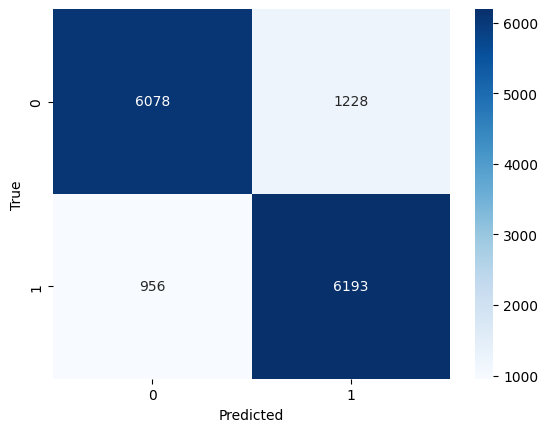

In [23]:
y_pred_xgb_le = xgb_default.predict(x_test)
y_pred_xgb = le.inverse_transform(y_pred_xgb_le)

metricas(y_pred_xgb, y_test)

### XGBoost optimizado

modelo de XGBoost con parametros optimizados a traves de la prueba de diferentes hiperparametros con RandomSearchCV

In [ ]:
parametros_optimos = {
    'subsample': 0.5,
    'reg_lambda': 4,
    'reg_alpha': 1,
    'n_estimators': 40,
    'max_depth': 8,
    'learning_rate': 0.15999999999999998,
    'gamma': 0.1,
    'colsample_bytree': 0.8
}

xgb_optimo = xgb.XGBClassifier(booster='gbtree', random_state=1010, **parametros_optimos)

xgb_optimo.fit(x_train, y_train_le)

              precision    recall  f1-score   support

    negativo       0.83      0.78      0.81      7306
    positivo       0.79      0.84      0.81      7149

    accuracy                           0.81     14455
   macro avg       0.81      0.81      0.81     14455
weighted avg       0.81      0.81      0.81     14455

Precision: 0.8298984034833091
Accuracy: 0.8090626080940851
Recall: 0.7826444018614838
F1-Score: 0.805579036348267



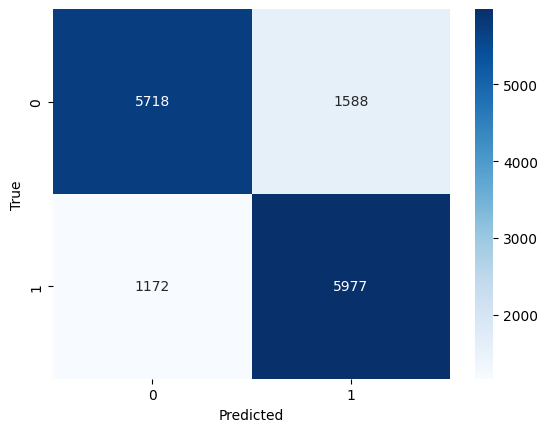

In [21]:
y_pred_xgb_optimo_le = xgb_optimo.predict(x_test)
y_pred_xgb_optimo = le.inverse_transform(y_pred_xgb_optimo_le)

metricas(y_pred_xgb_optimo, y_test)

## Modelo Bayes Naïve

In [33]:
param_grid_bayes = {
    'alpha': np.logspace(0,-9, num=100)
}

f1_score_ = make_scorer(f1_score, average='micro')

modelo_grid_bayes = GridSearchCV(estimator=MultinomialNB(), scoring=f1_score_, param_grid=param_grid_bayes, verbose=1, cv=10, n_jobs=-1)
modelo_grid_bayes.fit(x_train, y_train)

best_bayes = modelo_grid_bayes.best_estimator_
print(best_bayes)

MultinomialNB(alpha=0.2848035868435802)


              precision    recall  f1-score   support

    negativo       0.87      0.87      0.87      7306
    positivo       0.86      0.87      0.87      7149

    accuracy                           0.87     14455
   macro avg       0.87      0.87      0.87     14455
weighted avg       0.87      0.87      0.87     14455

Precision: 0.8722260509993108
Accuracy: 0.8682116914562436
Recall: 0.8661374212975637
F1-Score: 0.8691710734152874



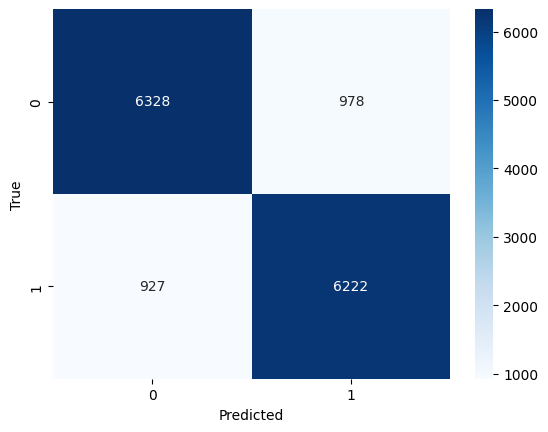

In [34]:
y_pred_grid_bayes = best_bayes.predict(x_test)

metricas(y_pred_grid_bayes, y_test)

##Random Forest


In [29]:
params_rf = {
    'n_estimators': [200, 300], #n de árboles
    'max_features': ['sqrt', 'log2'], #n de columnas a analizar para buscar el mejor split
    'max_depth': [None] + list(np.arange(10, 110, 10)), #Profundidad máxima de cada árbol
    'min_samples_split': [10, 15, 20], #minimo de casos para que el nodo se divida
    'min_samples_leaf': [10, 15, 20], #minimo de casos para que el nodo sea hoja
    'bootstrap': [True, False] #True -> Bagging
}

rf = RandomForestClassifier(random_state=1010)

random_search_rf = RandomizedSearchCV(rf, params_rf, scoring=f1_score_, cv=5, n_iter=20, random_state=1010)

random_search_rf.fit(x_train, y_train_le)

best_rf = random_search_rf.best_estimator_
print(best_rf)

RandomForestClassifier(max_depth=70, min_samples_leaf=10, min_samples_split=20,
                       n_estimators=200, random_state=1010)


              precision    recall  f1-score   support

    negativo       0.86      0.83      0.84      7306
    positivo       0.83      0.86      0.85      7149

    accuracy                           0.84     14455
   macro avg       0.84      0.84      0.84     14455
weighted avg       0.84      0.84      0.84     14455

Precision: 0.8589707136764287
Accuracy: 0.8439294361812522
Recall: 0.8269915138242541
F1-Score: 0.8426778242677825



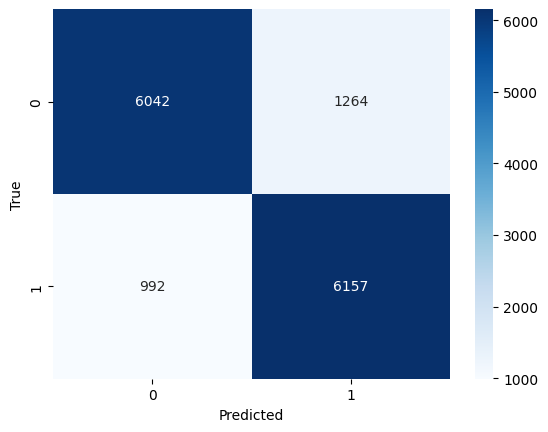

In [26]:
y_pred_rf_le = best_rf.predict(x_test)
y_pred_rf = le.inverse_transform(y_pred_rf_le)

metricas(y_pred_rf, y_test)

## Red neuronal

En esta parte realizaremos la red neuronal, para esto estableceremos la división de train/test sobre los textos sin vectorizar, ya que tras muchos intentos con TensorFlow, se generan muchos conflictos al usar vectorizadores que no son los que recomienda la documentación por temas de dimensionalidad.

In [ ]:
df_trabajo_x = df_trabajo.drop('sentimiento', axis='columns')

df_trabajo_y = df_trabajo['sentimiento'].copy()

x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=1010) #semilla

In [ ]:
import string
import re

le = LabelEncoder()
y_train_le_nn = le.fit_transform(y_train_nn)
y_test_le_nn = le.fit_transform(y_test_nn)

max_features = 10000
sequence_length = 500 # Largo de las secuencias independientemente de la
                       # cantidad de palabras halladas (funciona al usar
                       # output_mode =="int" nada mas)

x_train_numpy = x_train_nn['review_es'].to_numpy()
x_test_numpy = x_test_nn['review_es'].to_numpy()

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

raw_train_dataset = tf.data.Dataset.from_tensor_slices((x_train_numpy, y_train_le_nn))
raw_test_dataset = tf.data.Dataset.from_tensor_slices((x_test_numpy, y_test_le_nn))

vectorize_layer.adapt(x_train_numpy)

train_ds = raw_train_dataset.map(vectorize_text)
test_ds = raw_test_dataset.map(vectorize_text)

  # Para mejorar la performance, la documentación dice:
	# buffer_size arg: A tf.int64 scalar tf.Tensor, representing the maximum
  # number of elements that will be buffered when prefetching. If the value
  # tf.data.AUTOTUNE is used, then the buffer size is dynamically tuned.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [ ]:
#Agregamos una dimesión más para que sea posible la operación entre tensores
train_ds = train_ds.map(lambda x, y: (x, tf.expand_dims(y, -1)))
test_ds = test_ds.map(lambda x, y: (x, tf.expand_dims(y, -1)))

In [ ]:
embedding_dim = 32

red_neuronal = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.3),
  layers.GlobalAveragePooling1D(),
  layers.Dense(20),
  layers.Dropout(0.2),
  layers.Dense(1)])

red_neuronal.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[
        tfa.metrics.F1Score(num_classes=1, threshold=0.5),
    ]
)

epochs = 4
history = red_neuronal.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs)

In [ ]:
# Agregamos a la red neuronal una capa de vectorización asi de forma
# automática puede recibir texto y lo vectoriza a su disposición

red_neuronal_con_vectorizacion = tf.keras.Sequential([
  vectorize_layer,
  red_neuronal,
  layers.Activation('sigmoid')
])

red_neuronal_con_vectorizacion.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['f1']
)

Si bien al entrenar la red ya hacemos la parte de validación y se obtienen las métricas de desempeño ante el conjunto de test, agregamos este snippet para poder plottear lo obtenido como con los otros modelos e imprimer de forma más amena las métricas

In [ ]:
prob_pred_test = red_neuronal_con_vectorizacion.predict(x_test_numpy)
prob_pred_test_plot = []
for x in np.where(prob_pred_test > 0.5, 1, 0):
  prob_pred_test_plot.append(x[0])

pred_test_plot = le.inverse_transform(prob_pred_test_plot)

metricas(pred_test_plot, y_test_nn)

In [ ]:
ids_submit = df_trabajo_test['ID']
reviews_test = df_trabajo_test.drop('ID', axis='columns')
x_predict_data = reviews_test['review_es'].to_numpy()

prob_pred = red_neuronal_con_vectorizacion.predict(x_predict_data)

submit_pred_nn_le = []
for x in np.where(prob_pred > 0.5, 1, 0):
  submit_pred_nn_le.append(x[0])

submit_pred_nn = le.inverse_transform(submit_pred_nn_le)

df_submit_nn = pd.DataFrame(zip(ids_submit,submit_pred_nn),columns=['ID', 'sentimiento'])

df_submit_nn.head()

##Ensambles de modelos

En esta sección armaremos los ensambles de modelos, tras haber probado, para no hacer tan extensa la notebook, dejamos sólo el stacking, que fue el de mejor desempeño. Agregamos todos los modelos ya entrenados exceptuando la red neuronal, ya que el input de la misma es distinto al del resto, por los inconvenientes ya mencionados en la sección.

###Stacking

              precision    recall  f1-score   support

    negativo       0.91      0.90      0.90      7306
    positivo       0.89      0.91      0.90      7149

    accuracy                           0.90     14455
   macro avg       0.90      0.90      0.90     14455
weighted avg       0.90      0.90      0.90     14455

Precision: 0.9060207612456748
Accuracy: 0.9004496713939814
Recall: 0.8959759102107857
F1-Score: 0.9009703392746542



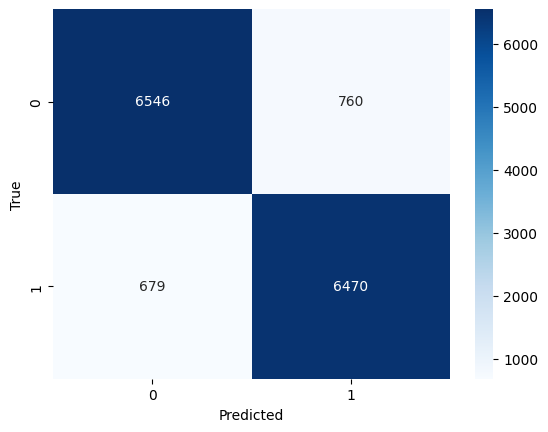

In [38]:
meta_model = LogisticRegressionCV(max_iter=1500)

estimadores = [


    ('bayes', best_bayes),
    ('xgb', xgb_default),
    ('rf', best_rf),
]


stacking_model = StackingClassifier(estimators=estimadores,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=3,
                                    verbose=2)

stacking_model.fit(x_train, y_train_le)
y_pred_stacking_le = stacking_model.predict(x_test)
y_pred_stacking = le.inverse_transform(y_pred_stacking_le)

metricas(y_pred_stacking, y_test)

## Exportación de modelos y submits

Exportación de modelos, descomentar según sea necesario

In [ ]:
# # XGBoost
# joblib.dump(xgb_default, '/content/drive/MyDrive/datasetsTP/modelos/modelo_xgb_default.joblib')

# # BAYES NAÏVE
# joblib.dump(best_bayes, '/content/drive/MyDrive/datasetsTP/modelos/modelo_bayes.joblib')

# # Random Forest
# joblib.dump(best_rf, '/content/drive/MyDrive/datasetsTP/modelos/modelo_rf.joblib')

# # Red Neuronal
# joblib.dump(red_neuronal_con_vectorizacion, '/content/drive/MyDrive/datasetsTP/modelos/modelo_red_neuronal.joblib')

# # Stacking
# joblib.dump(stacking_model, '/content/drive/MyDrive/datasetsTP/modelos/modelo_stacking.joblib')

Generaración de submits, descomentar según sea necesario

In [ ]:
# XGBoost
# df_submit_xgb_default = generar_df_submit(xgb_default)
# df_submit_xgb_default.info()

# # BAYES NAÏVE
# df_submit_bayes = generar_df_submit(best_bayes)
# df_submit_bayes.info()

# # Random Forest
# df_submit_rf = generar_df_submit(best_rf)
# df_submit_rf.info()

# # Stacking
# df_submit_stacking = generar_df_submit(stacking_model)
# df_submit_stacking.info()

Verificamos que contenga las columnas requeridas y un total de 8599 filas


Exportación de submits, descomentar según sea necesario

In [ ]:
# # XGBoost (default)
# df_submit_xgb_default.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_xgb_default.csv', index = False)

# # BAYES NAÏVE
# df_submit_bayes.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_bayes.csv', index = False)

# # Random Forest
# df_submit_rf.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_rf.csv', index = False)

# # Red Neuronal
# df_submit_nn.to_csv('/content/drive/MyDrive/datasetsTP/submits/tp2/submit_nn_tf_keras.csv', index = False)

# # Stacking
# df_submit_stacking.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_stacking.csv', index = False)